In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from math import log

In [ ]:
main_dataset = pd.read_csv("/Bitcoin_dataset_updated.csv")
block_size=pd.read_csv("/blocks-size.csv")
repo_rate=pd.read_csv("/repo rate.csv")

In [ ]:
main_dataset.head()

,Date,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
0,2014-01-02,749.27,54770.0,0.18,8,1225.0,1831.98,95.14,11089.3
1,2014-01-03,781.23,60980.0,NaN,8,1238.4,1831.37,93.66,11089.3
2,2014-01-04,807.39,52052.0,NaN,8,NaN,NaN,NaN,11089.3
3,2014-01-05,828.74,58662.0,0.38,8,NaN,NaN,NaN,11089.3
4,2014-01-06,904.98,67358.0,NaN,8,1237.8,1826.77,93.12,11089.3


In [ ]:
block_size.head()

,2009-01-03 00:00:00,0.000285
0,2009-01-11 00:00:00,0.016639
1,2009-01-14 00:00:00,0.085231
2,2009-01-17 00:00:00,0.167422
3,2009-01-20 00:00:00,0.241267
4,2009-01-23 00:00:00,0.310038


In [ ]:
block_size['date']=block_size['2009-01-03 00:00:00'].str[:10]
block_size.drop('2009-01-03 00:00:00',axis=1,inplace=True)
block_size.head()

,0.000285,date
0,0.016639,2009-01-11
1,0.085231,2009-01-14
2,0.167422,2009-01-17
3,0.241267,2009-01-20
4,0.310038,2009-01-23


In [ ]:
repo_rate['repo rate'] = repo_rate['repo rate'].str.rstrip('%').astype('float') 
repo_rate.date = pd.to_datetime(repo_rate.date)

In [ ]:
main_dataset.Date = pd.to_datetime(main_dataset.Date)
block_size.date = pd.to_datetime(block_size.date)
main_dataset.rename(columns={"BTC price [USD]":"price","Gold price":"gold_price","SP500 close index":"index","Oil WTI price[USD]":"oil_price"}, inplace= True)

In [ ]:
df=main_dataset.merge(block_size, how='left',left_on='Date',right_on='date')
df.head()

,Date,price,n-transactions,fee [USD],btc search trends,Gold price[USD],index,oil_price,M2(Not seasonally adjusted)[1e+09 USD],0.000285,date
0,2014-01-02,749.27,54770.0,0.18,8,1225.0,1831.98,95.14,11089.3,NaN,NaT
1,2014-01-03,781.23,60980.0,NaN,8,1238.4,1831.37,93.66,11089.3,14093.986991,2014-01-03
2,2014-01-04,807.39,52052.0,NaN,8,NaN,NaN,NaN,11089.3,NaN,NaT
3,2014-01-05,828.74,58662.0,0.38,8,NaN,NaN,NaN,11089.3,NaN,NaT
4,2014-01-06,904.98,67358.0,NaN,8,1237.8,1826.77,93.12,11089.3,14184.012024,2014-01-06


In [ ]:
main_dataset.shape

(2310, 9)

In [ ]:
df.shape

(2310, 11)

In [ ]:
df=df.drop('date',axis=1)

In [ ]:
df=df.rename(columns={'0.000285':'block_size'})

In [ ]:
df=df.merge(repo_rate, how='left',left_on='Date',right_on='date')
df.head()

,Date,price,n-transactions,fee [USD],btc search trends,Gold price[USD],index,oil_price,M2(Not seasonally adjusted)[1e+09 USD],block_size,date,repo rate
0,2014-01-02,749.27,54770.0,0.18,8,1225.0,1831.98,95.14,11089.3,NaN,NaT,NaN
1,2014-01-03,781.23,60980.0,NaN,8,1238.4,1831.37,93.66,11089.3,14093.986991,NaT,NaN
2,2014-01-04,807.39,52052.0,NaN,8,NaN,NaN,NaN,11089.3,NaN,NaT,NaN
3,2014-01-05,828.74,58662.0,0.38,8,NaN,NaN,NaN,11089.3,NaN,NaT,NaN
4,2014-01-06,904.98,67358.0,NaN,8,1237.8,1826.77,93.12,11089.3,14184.012024,NaT,NaN


In [ ]:
df.isnull().sum()

Date                                         0
price                                        0
n-transactions                               0
fee [USD]                                  844
btc search trends                            0
Gold price[USD]                            639
index                                      718
oil_price                                  723
M2(Not seasonally adjusted)[1e+09 USD]       0
block_size                                1540
date                                      2294
repo rate                                 2294
dtype: int64

In [ ]:
df=df.drop(['M2(Not seasonally adjusted)[1e+09 USD]','date'],axis=1)

In [ ]:
df = df.set_index(['Date'])

In [ ]:
df = df.fillna(df.interpolate(method='time'))

In [ ]:
df=df.dropna(axis=0)
df.isnull().sum()

price                0
n-transactions       0
fee [USD]            0
btc search trends    0
Gold price[USD]      0
index                0
oil_price            0
block_size           0
repo rate            0
dtype: int64

Text(0, 0.5, 'Price')

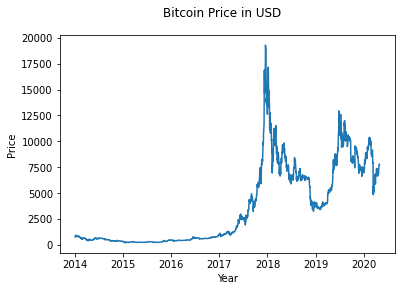

In [ ]:
fig = plt.figure()
plt.plot(main_dataset.Date, main_dataset.price)
plt.suptitle("Bitcoin Price in USD")
plt.xlabel("Year")
plt.ylabel("Price")

In [ ]:
df.columns

Index(['price', 'n-transactions', 'fee [USD]', 'btc search trends',
       'Gold price[USD]', 'index', 'oil_price', 'block_size', 'repo rate'],
      dtype='object')

In [ ]:
X = df[['n-transactions', 'fee [USD]', 'btc search trends',
       'Gold price[USD]', 'index', 'oil_price', 'block_size', 'repo rate']]

In [ ]:

vif_data = pd.DataFrame()

vif_data["feature"] = X.columns
  
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

             feature         VIF
0     n-transactions   21.721366
1          fee [USD]    4.216751
2  btc search trends    7.080385
3    Gold price[USD]  274.327877
4              index  358.888385
5          oil_price   18.810035
6         block_size   72.285551
7          repo rate  355.234089


In [ ]:
#adding a constant, which isn't present by default in OLS
from statsmodels.tools.tools import add_constant

X = add_constant(X)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const                1587.060331
n-transactions          5.659549
fee [USD]               3.811662
btc search trends       4.590736
Gold price[USD]         1.969104
index                  12.751218
oil_price               2.444792
block_size             22.375078
repo rate              14.619406
dtype: float64

In [ ]:
X['index']=np.square(X['index'])
X['block_size']=np.square(X['block_size'])
X['repo rate']=np.square(X['repo rate'])

In [ ]:
X = add_constant(X)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const                578.499112
n-transactions         5.554029
fee [USD]              3.737747
btc search trends      4.311542
Gold price[USD]        2.326248
index                 10.139377
oil_price              2.637977
block_size            10.558585
repo rate             11.113545
dtype: float64

In [ ]:
X['index']=np.power(X['index'],3)
X['block_size']=np.power(X['block_size'],3)
X['repo rate']=np.power(X['repo rate'],3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
X = add_constant(X)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


const                0.000000
n-transactions       4.176800
fee [USD]            3.686067
btc search trends    1.384005
Gold price[USD]      0.848549
index                7.494609
oil_price            2.711086
block_size           7.455249
repo rate            8.175881
dtype: float64

In [ ]:
df = df.sort_index()
df.head()

,price,n-transactions,fee [USD],btc search trends,Gold price[USD],index,oil_price,block_size,repo rate
Date,,,,,,,,,
2014-01-28,747.57,65762.0,0.17,8,1251.000000,1792.500000,97.49,14846.773439,8.000000
2014-01-29,785.60,59682.0,0.17,8,1262.200000,1774.200000,97.34,14878.448171,7.999290
2014-01-30,794.00,60799.0,0.17,8,1242.200000,1794.190000,98.25,14910.122904,7.998580
2014-01-31,800.00,60269.0,0.17,8,1240.100000,1782.590000,97.55,14940.242085,7.997869
2014-02-01,803.00,54838.0,0.17,9,1246.866667,1769.023333,97.18,14970.361266,7.997159


In [ ]:
df.tail()

,price,n-transactions,fee [USD],btc search trends,Gold price[USD],index,oil_price,block_size,repo rate
Date,,,,,,,,,
2020-04-25,7507.08,280805.0,0.75,16,1731.666667,2850.653333,14.716667,273856.325797,5.4
2020-04-26,7549.52,252833.0,0.62,16,1727.733333,2864.566667,13.443333,274016.989804,5.4
2020-04-27,7699.27,311217.0,0.69,16,1723.800000,2878.480000,12.170000,274177.653811,5.4
2020-04-28,7790.66,323475.0,0.66,16,1722.200000,2863.390000,12.400000,274338.317818,5.4
2020-04-29,7765.33,331401.0,1.30,16,1713.400000,2939.510000,15.040000,274338.317818,5.4


In [ ]:
df['index']=np.power(df['index'],3)
df['block_size']=np.power(df['block_size'],3)
df['repo rate']=np.power(df['repo rate'],3)

In [ ]:
train = df['2014-01-28':'2019-12-31']
test  = df['2020-01-01':]
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)

Train Dataset: (1799, 9)
Test Dataset: (365, 9)


In [ ]:
train_X=train[['n-transactions', 'fee [USD]', 'btc search trends',
       'Gold price[USD]', 'index', 'oil_price', 'block_size', 'repo rate']]
train_Y=train['price']
test_X=test[['n-transactions', 'fee [USD]', 'btc search trends',
       'Gold price[USD]', 'index', 'oil_price', 'block_size', 'repo rate']]
test_Y=test['price']

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
train=train.rename(columns={'n-transactions':'txn','fee [USD]':'fee','btc search trends':'search_trends','Gold price[USD]':'gold_price','repo rate':'repo_rate'})

In [ ]:
test=test.rename(columns={'n-transactions':'txn','fee [USD]':'fee','btc search trends':'search_trends','Gold price[USD]':'gold_price','repo rate':'repo_rate'})

In [ ]:
lm1=smf.ols(formula= 'price ~ txn + fee + search_trends + gold_price + index + oil_price + block_size + repo_rate' ,data=train).fit()

In [ ]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3991.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:34:59   Log-Likelihood:                -14853.
No. Observations:                1799   AIC:                         2.972e+04
Df Residuals:                    1792   BIC:                         2.976e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.2993      0.005    -55.323      0.000      -0.310      -0.289
txn              -0.0088      0.001    -16.546      0.000      -0.010      -0.008
fee              38.3357      0.531     72.135      0.000      37.293      39.378
search_trends   126.8351      1.757     72.189      0.000     123.389     130.281
gold_price        0.0715      0.225      0.319      0.750      -0.369       0.512
index           2.73e-07   1.33e-08     20.490      0.000    2.47e-07    2.99e-07
oil_price        16.0745      1.989      8.080      0.000      12.173      19.976
block_size     2.182e-13   2.84e-14      7.677      0.000    1.62e-13    2.74e-13
repo_rate        -6.0394      0.611     -9.881      0.000      -7.238      -4.841
==============================================================================
Omnibus:                      592.681   Durbin-Watson:                   0.202
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5640.677
Skew:                           1.264   Prob(JB):                         0.00
Kurtosis:                      11.298   Cond. No.                     5.88e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.88e+16. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
lm2=smf.ols(formula= 'price ~ txn + fee + search_trends + index + oil_price + block_size + repo_rate' ,data=train).fit()

In [ ]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     4798.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:49:25   Log-Likelihood:                -14852.
No. Observations:                1799   AIC:                         2.972e+04
Df Residuals:                    1793   BIC:                         2.975e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.5783      0.008    -74.038      0.000      -0.594      -0.563
txn              -0.0087      0.000    -25.556      0.000      -0.009      -0.008
fee              39.3814      0.479     82.249      0.000      38.442      40.320
search_trends   126.2339      1.532     82.379      0.000     123.229     129.239
index          2.754e-07   1.11e-08     24.861      0.000    2.54e-07    2.97e-07
oil_price        16.0604      1.986      8.086      0.000      12.165      19.956
block_size     2.164e-13   2.75e-14      7.858      0.000    1.62e-13     2.7e-13
repo_rate        -5.8865      0.382    -15.394      0.000      -6.637      -5.137
==============================================================================
Omnibus:                      589.199   Durbin-Watson:                   0.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5531.412
Skew:                           1.259   Prob(JB):                         0.00
Kurtosis:                      11.213   Cond. No.                     3.93e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+16. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
df = df.reset_index()

Text(0, 0.5, 'Price')

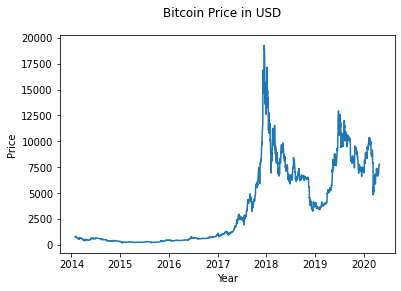

In [ ]:
fig = plt.figure()
plt.plot(df.Date, df.price)
plt.suptitle("Bitcoin Price in USD")
plt.xlabel("Year")
plt.ylabel("Price")

Text(0, 0.5, 'Block Size ^3')

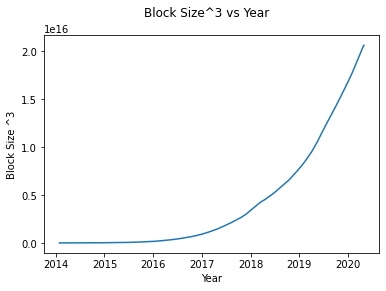

In [ ]:
fig = plt.figure()
plt.plot(df.Date, df.block_size)
plt.suptitle("Block Size^3 vs Year")
plt.xlabel("Year")
plt.ylabel("Block Size ^3")

Text(0, 0.5, 'Number of transactions')

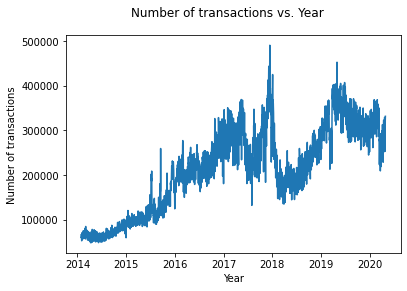

In [ ]:
fig = plt.figure()
plt.plot(df.Date, df['n-transactions'])
plt.suptitle("Number of transactions vs. Year")
plt.xlabel("Year")
plt.ylabel("Number of transactions")

Text(0, 0.5, 'Oil Price')

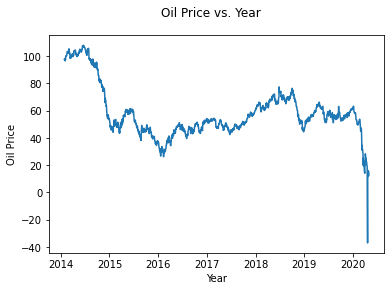

In [ ]:
fig = plt.figure()
plt.plot(df.Date, df.oil_price)
plt.suptitle("Oil Price vs. Year")
plt.xlabel("Year")
plt.ylabel("Oil Price")

In [ ]:
df = df.resample('M').mean()
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df.price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df.price)[1])
plt.show()

NameError: ignored